<a href="https://colab.research.google.com/github/madaam99/FinanicalFraudClassification/blob/main/FinancialFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ealaxi/paysim1")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'paysim1' dataset.
Path to dataset files: /kaggle/input/paysim1


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 18.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import optuna

from sklearn.metrics import recall_score, precision_score, roc_auc_score, precision_recall_curve, f1_score, confusion_matrix, classification_report

from sklearn.calibration import CalibratedClassifierCV

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv(path + "/PS_20174392719_1491204439457_log.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
amountFraud = data['isFraud'].sum()
amountLegit = data.shape[0] - amountFraud

print(f"Total amount of fraudulant transactions: {amountFraud}")
print(f"Total amount of legit transactions: {amountLegit}")
print(f"Percentage of frauds: {round(((amountFraud/data.shape[0])*100), 2)}%")

Total amount of fraudulant transactions: 8213
Total amount of legit transactions: 6354407
Percentage of frauds: 0.13%


EDA

Text(0.5, 1.0, 'Fraud vs. Non-Fraud Counts')

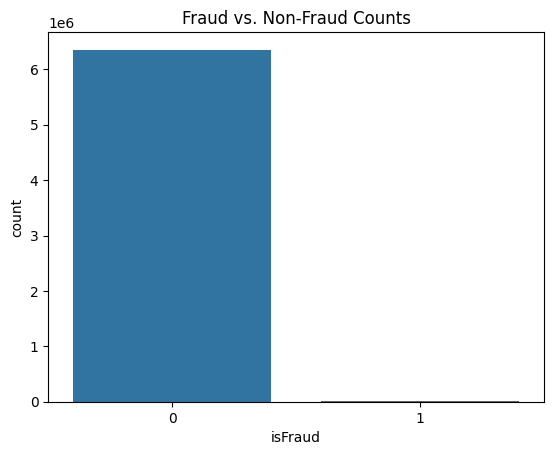

In [8]:
sns.countplot(x='isFraud', data=data)
plt
plt.title("Fraud vs. Non-Fraud Counts")

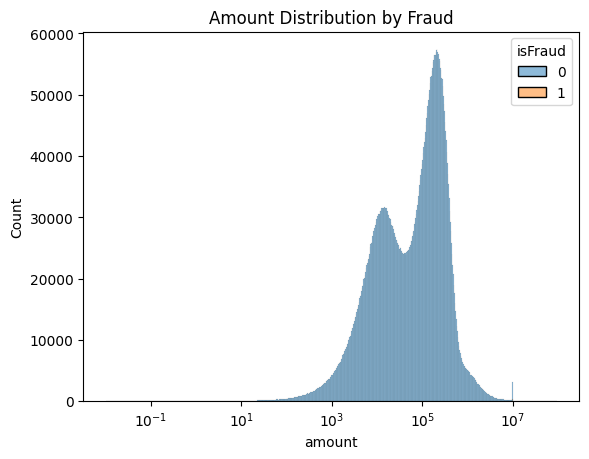

In [9]:
sns.histplot(data=data, x='amount', hue="isFraud", log_scale=True)
plt.title("Amount Distribution by Fraud")
plt.show()

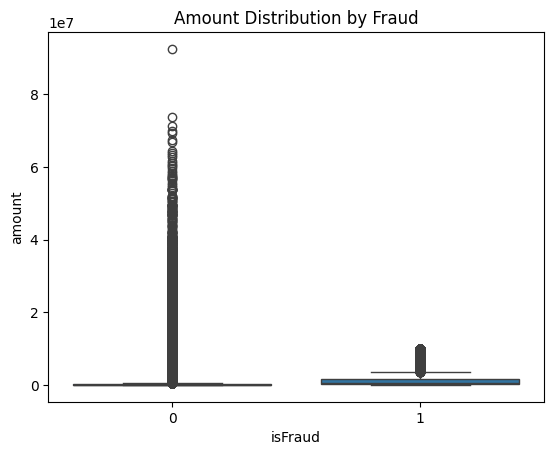

In [10]:
sns.boxplot(x='isFraud', y='amount', data=data)
plt.title("Amount Distribution by Fraud")
plt.show()

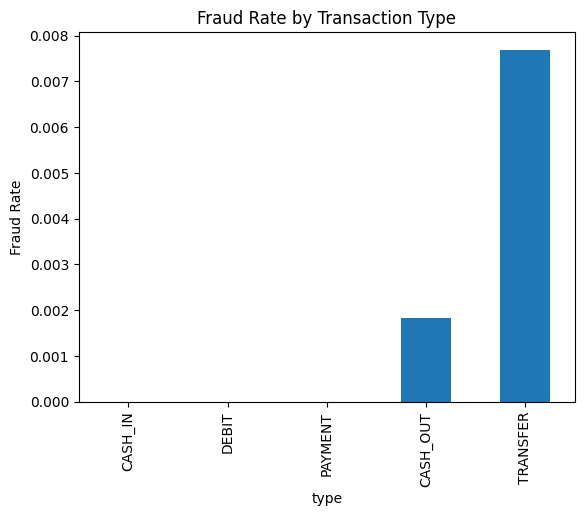

In [11]:
data[["type", "isFraud"]].groupby('type')['isFraud'].mean().sort_values().plot.bar()
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Transaction Type')
plt.show()

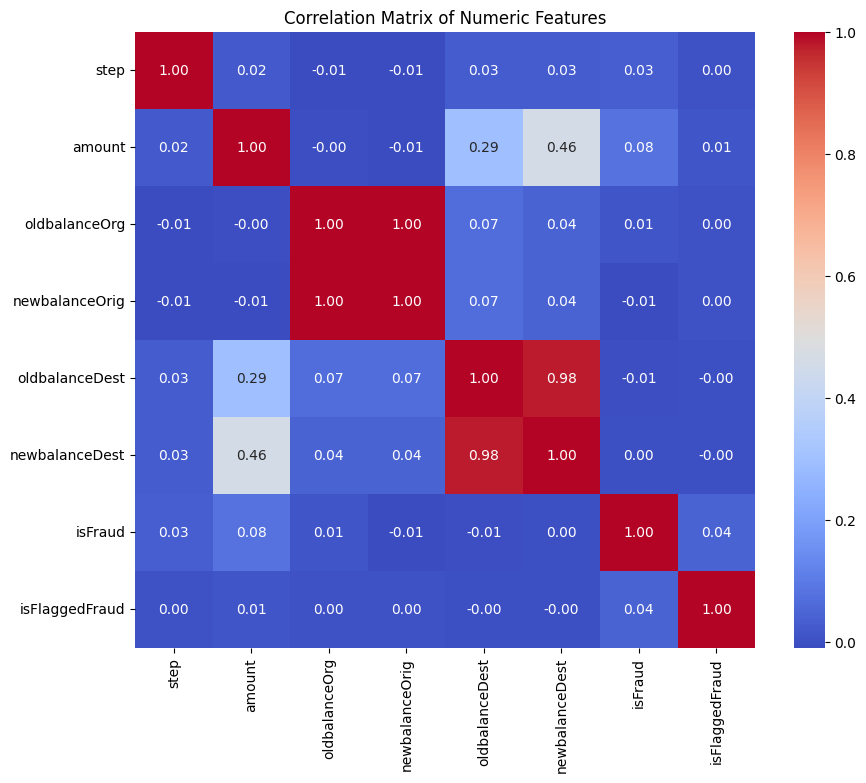

In [12]:
numeric_data = data.select_dtypes(include=['number'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

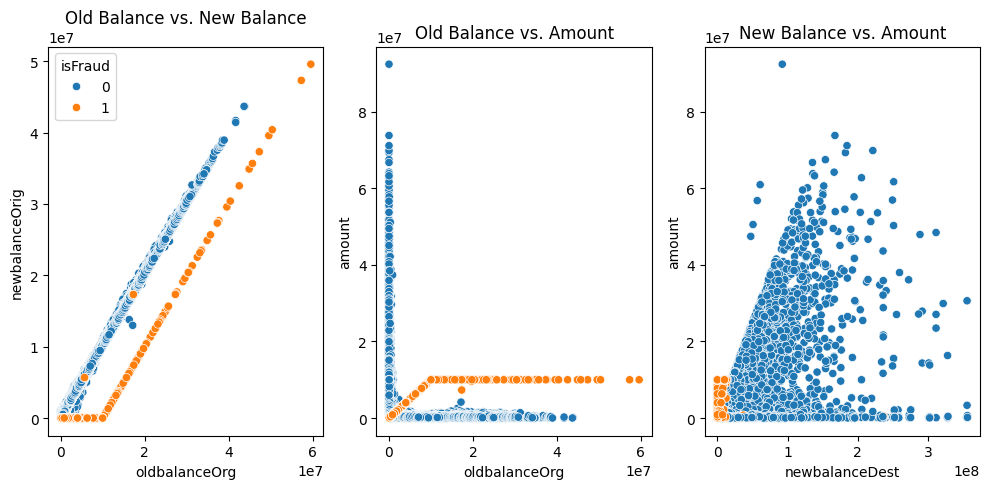

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
sns.scatterplot(data=data, x='oldbalanceOrg', y='newbalanceOrig', hue='isFraud', ax=ax[0])
ax[0].set_title('Old Balance vs. New Balance')
sns.scatterplot(data=data, x="oldbalanceOrg", y="amount", hue="isFraud", ax=ax[1], legend=False)
ax[1].set_title('Old Balance vs. Amount')
sns.scatterplot(data=data, x="newbalanceDest", y="amount", hue="isFraud", ax=ax[2], legend=False)
ax[2].set_title('New Balance vs. Amount')
plt.tight_layout()
plt.show()

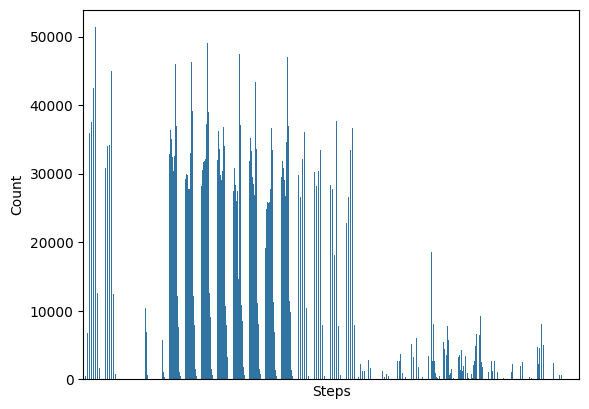

In [14]:
# Checking whether steps (time) are relevant for the simulation of frauds
a = data[["step", "isFraud"]].groupby("step").count()

sns.barplot(x=a.index, y=a["isFraud"])
plt.xlabel("Steps")
plt.ylabel("Count")
plt.xticks([])
plt.show()

In [15]:
temp = data.loc[(data['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
temp = temp.drop(columns=['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'])
temp = temp.reset_index(drop=True)
temp.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
2,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
3,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
4,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


Plotting distribution for column: amount


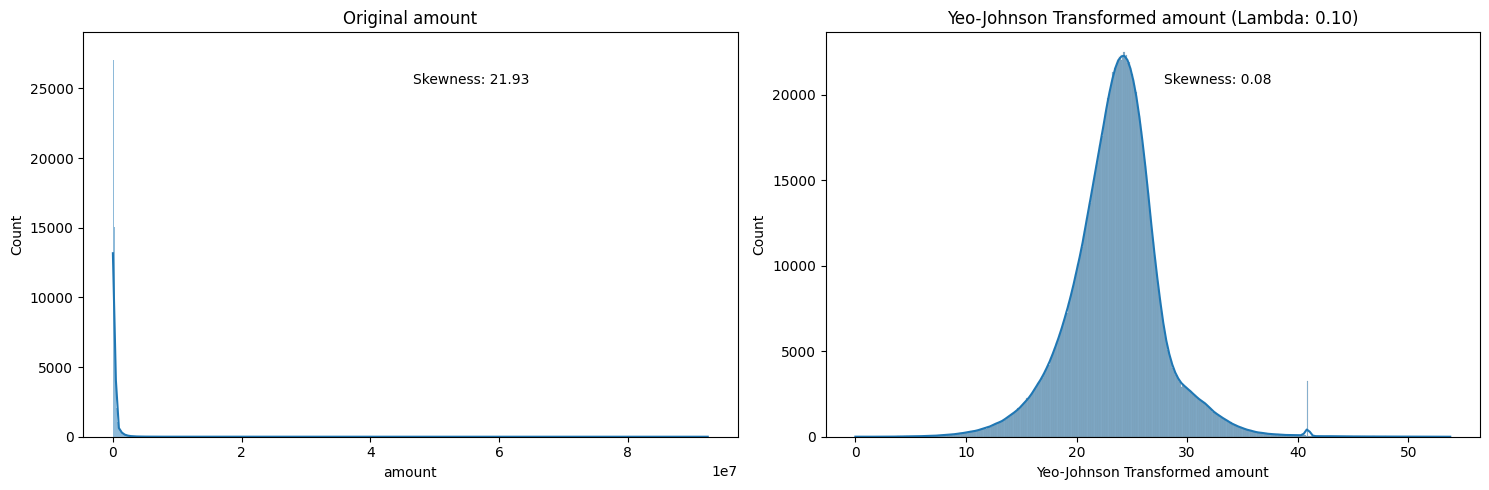

--------------------------------------------------
Plotting distribution for column: oldbalanceOrg


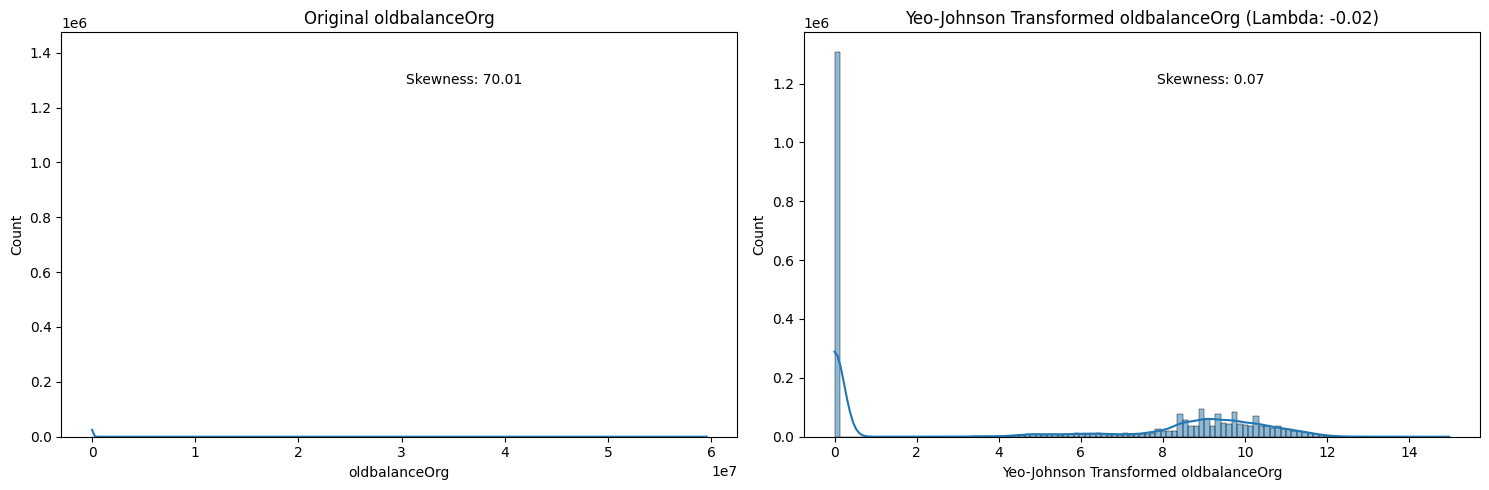

--------------------------------------------------
Plotting distribution for column: newbalanceOrig


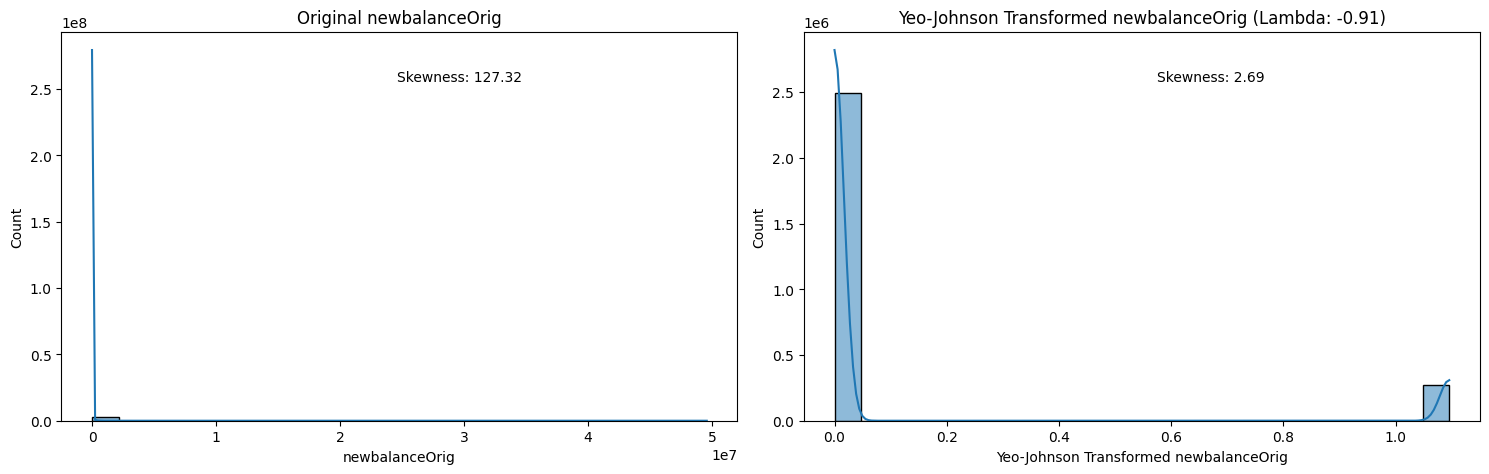

--------------------------------------------------
Plotting distribution for column: oldbalanceDest


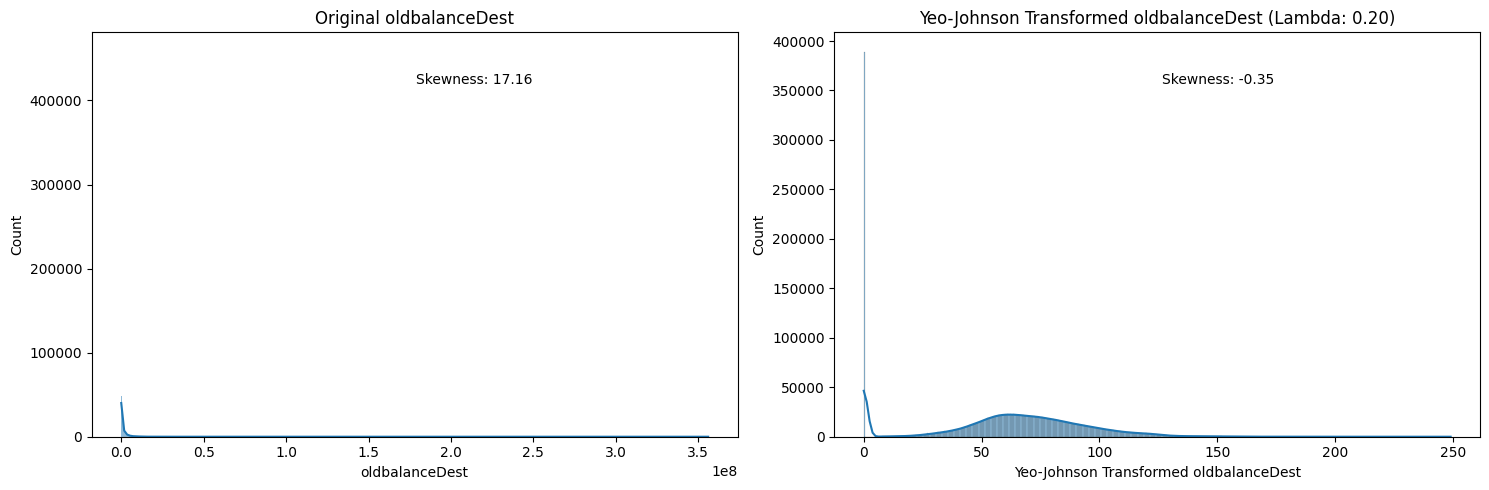

--------------------------------------------------
Plotting distribution for column: newbalanceDest


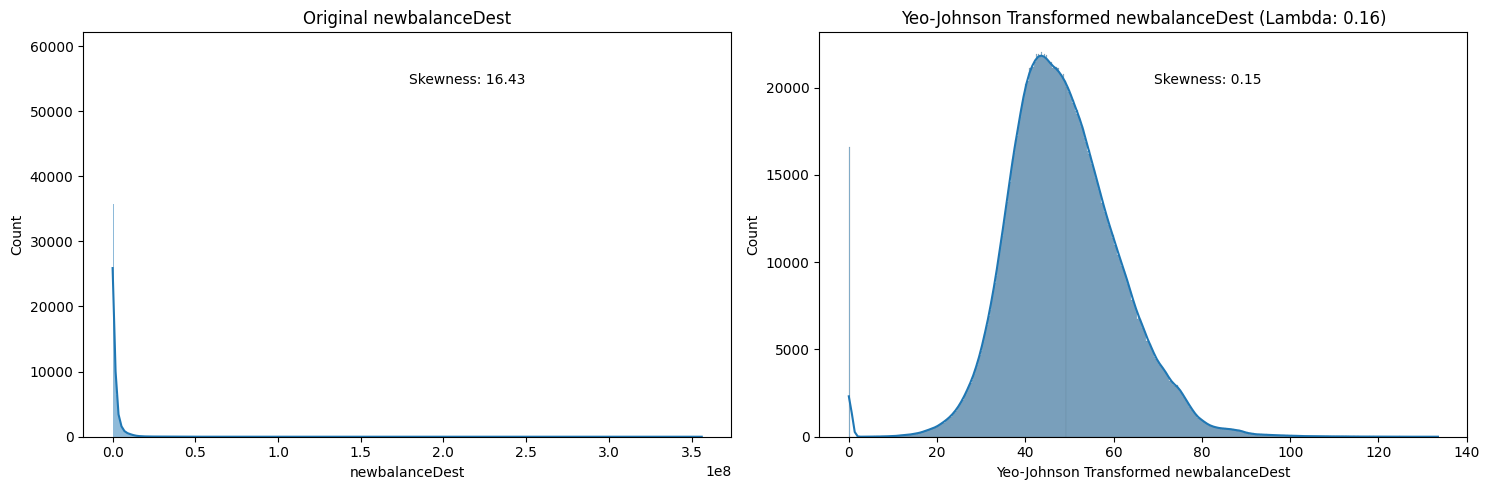

--------------------------------------------------


In [16]:
def plot_yeojohnson_transformation(df, original_columns, transformed_columns, lambda_values):
    """
    Plots the original and Yeo-Johnson transformed distributions for specified columns
    with skewness annotations.

    Args:
        df (pd.DataFrame): The input DataFrame containing both original and transformed columns.
        original_columns (list): A list of original column names.
        transformed_columns (list): A list of corresponding transformed column names.
        lambda_values (dict): A dictionary mapping original column names to their lambda values.
    """
    for original_col, transformed_col in zip(original_columns, transformed_columns):
        print(f"Plotting distribution for column: {original_col}")

        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        # Plot original distribution
        sns.histplot(df[original_col], ax=ax[0], kde=True)
        ax[0].set_title(f"Original {original_col}")
        ax[0].set_xlabel(original_col)
        ax[0].text(df[original_col].max()*0.7, ax[0].get_ylim()[1]*0.9, f"Skewness: {skew(df[original_col]):.2f}",
                   horizontalalignment='right', verticalalignment='top')

        # Plot Yeo-Johnson transformed distribution
        sns.histplot(df[transformed_col], ax=ax[1], kde=True)
        ax[1].set_title(f"Yeo-Johnson Transformed {original_col} (Lambda: {lambda_values.get(original_col, 'N/A'):.2f})")
        ax[1].set_xlabel(f"Yeo-Johnson Transformed {original_col}")
        ax[1].text(df[transformed_col].max()*0.7, ax[1].get_ylim()[1]*0.9, f"Skewness: {skew(df[transformed_col]):.2f}",
                   horizontalalignment='right', verticalalignment='top')

        plt.tight_layout()
        plt.show()

        print("-" * 50) # Separator for clarity

columns_to_transform = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
transformed_cols = [f'{col}_yeojohnson' for col in columns_to_transform]
lambda_values = {}

for col in columns_to_transform:
    temp[f'{col}_yeojohnson'], lambda_values[col] = stats.yeojohnson(temp[col])

plot_yeojohnson_transformation(temp, columns_to_transform, transformed_cols, lambda_values)

### Preprocessing

In [17]:
df = data.copy()

In [18]:
# Checking whether "isFraud" is always 1 when "isFlaggedFraud" is
flagged_fraud_transactions = df[df['isFlaggedFraud'] == 1]

if (flagged_fraud_transactions['isFraud'] == 1).all():
  print("When 'isFlaggedFraud' is 1, 'isFraud' is always 1.")
else:
  print("There are cases where 'isFlaggedFraud' is 1, but 'isFraud' is not 1.")

When 'isFlaggedFraud' is 1, 'isFraud' is always 1.


In [19]:
# Checking whether sender is never recipient
all(df["nameOrig"]!=df["nameDest"])

True

Since there is not such a case, let's extract the letter to create a new feature..

In [20]:
import re

def normalizeNum(val):
  return re.sub(r"\d+", "", val)

In [21]:
df["sendDest"] = df["nameOrig"] + df["nameDest"]
df["sendDest"] = df["sendDest"].apply(normalizeNum)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,sendDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,CM
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,CM
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,CC
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,CC
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,CM


In [22]:
df["destDiff"] = df["newbalanceDest"] - df["oldbalanceDest"]
df["orgDiff"] = df["newbalanceOrig"] - df["oldbalanceOrg"]
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,sendDest,destDiff,orgDiff
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,CM,0.0,-9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,CM,0.0,-1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,CC,0.0,-181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,CC,-21182.0,-181.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,CM,0.0,-11668.14


In [23]:
# Those frauds where the recipient gains
dfFraudOver = df[(df['isFraud'] == 1) & (df["destDiff"] > 0)]
dfFraudOver

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,sendDest,destDiff,orgDiff
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.00,12145.85,1,0,CC,5877.85,-20128.00
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.00,9291619.62,1,0,CC,9291517.62,0.00
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.00,2444985.19,1,0,CC,2444985.19,-1277212.77
1870,1,CASH_OUT,25071.46,C1275464847,25071.46,0.0,C1364913072,9083.76,34155.22,1,0,CC,25071.46,-25071.46
1911,1,CASH_OUT,132842.64,C13692003,4499.08,0.0,C297927961,0.00,132842.64,1,0,CC,132842.64,-4499.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362611,742,CASH_OUT,63416.99,C994950684,63416.99,0.0,C1662241365,276433.18,339850.17,1,0,CC,63416.99,-63416.99
6362613,743,CASH_OUT,1258818.82,C1436118706,1258818.82,0.0,C1240760502,503464.50,1762283.33,1,0,CC,1258818.83,-1258818.82
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0,CC,339682.13,-339682.13
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0,CC,6311409.27,-6311409.28


In [24]:
dfFraudOver["type"].value_counts()

,count
type,
CASH_OUT,4072
TRANSFER,28


So about half...

In [25]:
# Amount of instances where amount does not correspond with the delta of the originators account
inconAmount = df[df["amount"] != np.abs(df['orgDiff'])].shape[0]
inconAmount

5433525

In [26]:
# What type do fraudulant activities belong to?
fraudData = df[df['isFraud'] == 1]
fraudData[["type", "isFraud"]].groupby('type').count()

,isFraud
type,
CASH_OUT,4116
TRANSFER,4097


In [27]:
# Is there a "nameDest" that is flagged for fraud more than once?
destCohort = data[["nameDest", "isFraud"]].groupby("nameDest").sum()
destCohort = destCohort[destCohort["isFraud"] > 1].sort_values(by="isFraud", ascending=False)
destCohort.head()

,isFraud
nameDest,
C1013511446,2
C104038589,2
C105660024,2
C1148781766,2
C1185292292,2


So rather unimportant...

In [28]:
fraudList = ["CASH_OUT", "TRANSFER"]

df = df.loc[df["type"].isin(fraudList), :]
df = df.reset_index(drop=True)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,sendDest,destDiff,orgDiff
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,CC,0.00,-181.0
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,CC,-21182.00,-181.0
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,CC,46430.44,-15325.0
3,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,CC,-22425.00,-705.0
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,CC,2712905.89,-10835.0


In [29]:
amountFraud = df['isFraud'].sum()
amountLegit = df.shape[0] - amountFraud

print(f"Total amount of fraudulant transactions: {amountFraud}")
print(f"Total amount of legit transactions: {amountLegit}")
print(f"Percentage of frauds: {round(((amountFraud/df.shape[0])*100), 2)}%")

Total amount of fraudulant transactions: 8213
Total amount of legit transactions: 2762196
Percentage of frauds: 0.3%


In [30]:
#Labelling to groups based on positive differences or negative ones
#temp = df.copy()

df["destGroup"] = df['destDiff'].apply(lambda x: 1 if x > 0 else 0)
df["orgGroup"] = df['orgDiff'].apply(lambda x: 1 if x > 0 else 0)

print(df["destGroup"].value_counts())
print(df["orgGroup"].value_counts())

destGroup
1    2721666
0      48743
Name: count, dtype: int64
orgGroup
0    2770407
1          2
Name: count, dtype: int64


In [31]:
le = LabelEncoder()
df["typeLabel"] = le.fit_transform(df["type"])
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,sendDest,destDiff,orgDiff,destGroup,orgGroup,typeLabel
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,CC,0.00,-181.0,0,0,1
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,CC,-21182.00,-181.0,0,0,0
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,CC,46430.44,-15325.0,1,0,0
3,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,CC,-22425.00,-705.0,0,0,1
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,CC,2712905.89,-10835.0,1,0,1


In [32]:
# Checking the values of sender to recipient
df['sendDest'].unique()

array(['CC'], dtype=object)

No added value with this information so I scrap this feature...

In [33]:
droppableColumns = ["nameOrig", "nameDest", "isFlaggedFraud", "step", "type", "sendDest"]

typeLabelMap = {
    0: "CASH_OUT",
    1: "TRANSFER"
}

df = df.drop(columns=droppableColumns)
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,destDiff,orgDiff,destGroup,orgGroup,typeLabel
0,181.00,181.0,0.0,0.0,0.00,1,0.00,-181.0,0,0,1
1,181.00,181.0,0.0,21182.0,0.00,1,-21182.00,-181.0,0,0,0
2,229133.94,15325.0,0.0,5083.0,51513.44,0,46430.44,-15325.0,1,0,0
3,215310.30,705.0,0.0,22425.0,0.00,0,-22425.00,-705.0,0,0,1
4,311685.89,10835.0,0.0,6267.0,2719172.89,0,2712905.89,-10835.0,1,0,1


Now to scaling and normalizing the data...

In [34]:
# Normalize the data with Yeo-Johnson transformation
columns_to_transform = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "destDiff", "orgDiff"]
transformed_cols = [f'{col}_yeojohnson' for col in columns_to_transform]
lambda_values = {}

for col in columns_to_transform:
    df[f'{col}_yeojohnson'], lambda_values[col] = stats.yeojohnson(df[col])

df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,destDiff,orgDiff,destGroup,orgGroup,typeLabel,amount_yeojohnson,oldbalanceOrg_yeojohnson,newbalanceOrig_yeojohnson,oldbalanceDest_yeojohnson,newbalanceDest_yeojohnson,destDiff_yeojohnson,orgDiff_yeojohnson
0,181.00,181.0,0.0,0.0,0.00,1,0.00,-181.0,0,0,1,6.863829,4.935684,0.0,0.000000,0.000000,0.000000,-38.573995
1,181.00,181.0,0.0,21182.0,0.00,1,-21182.00,-181.0,0,0,0,6.863829,4.935684,0.0,31.512813,0.000000,-50457.163407,-38.573995
2,229133.94,15325.0,0.0,5083.0,51513.44,0,46430.44,-15325.0,1,0,0,24.702539,8.743900,0.0,22.469813,28.581080,18241.023704,-617.967547
3,215310.30,705.0,0.0,22425.0,0.00,0,-22425.00,-705.0,0,0,1,24.484368,6.137151,0.0,31.930324,0.000000,-53712.359526,-91.150673
4,311685.89,10835.0,0.0,6267.0,2719172.89,0,2712905.89,-10835.0,1,0,1,25.801888,8.458434,0.0,23.640979,58.738229,720188.141425,-498.654145


Plotting distribution for column: amount


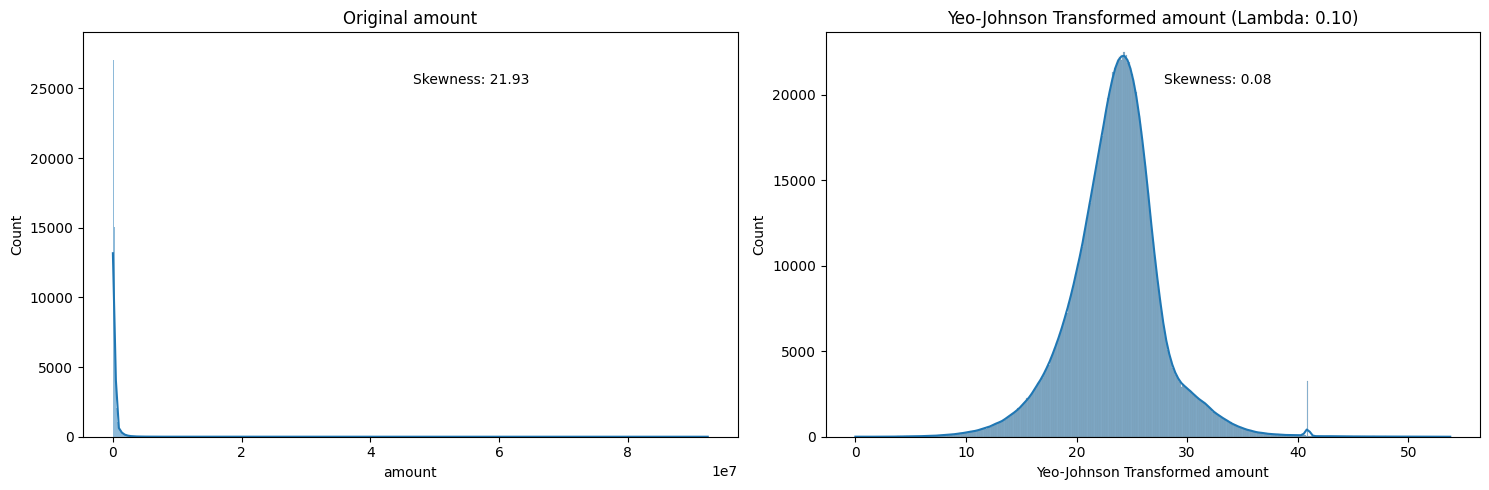

--------------------------------------------------
Plotting distribution for column: oldbalanceOrg


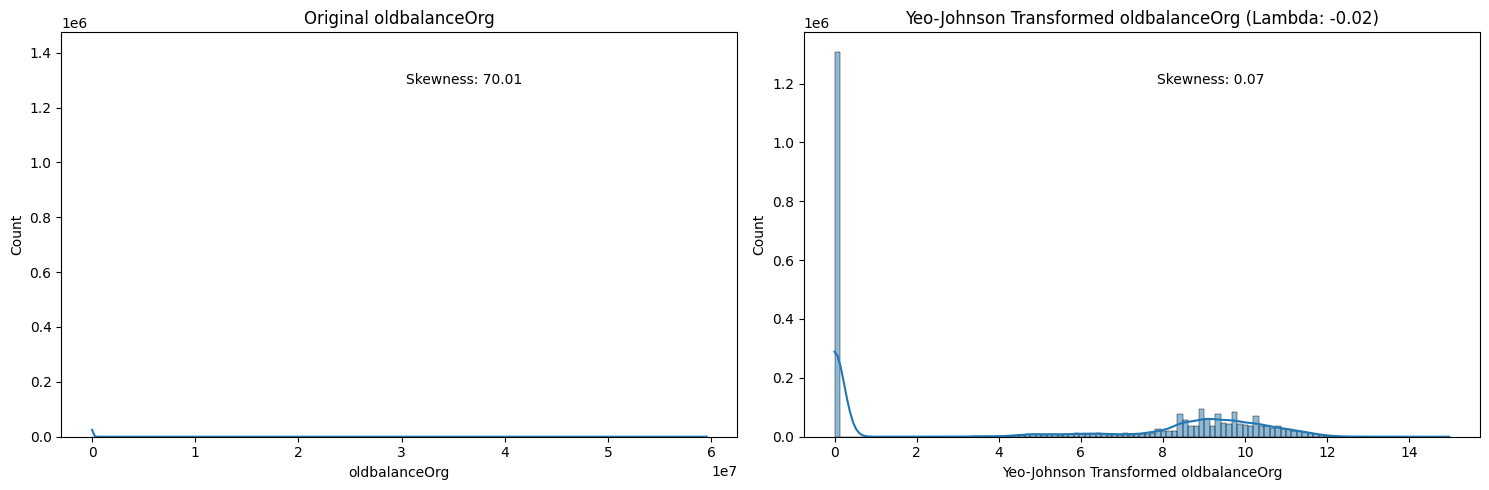

--------------------------------------------------
Plotting distribution for column: newbalanceOrig


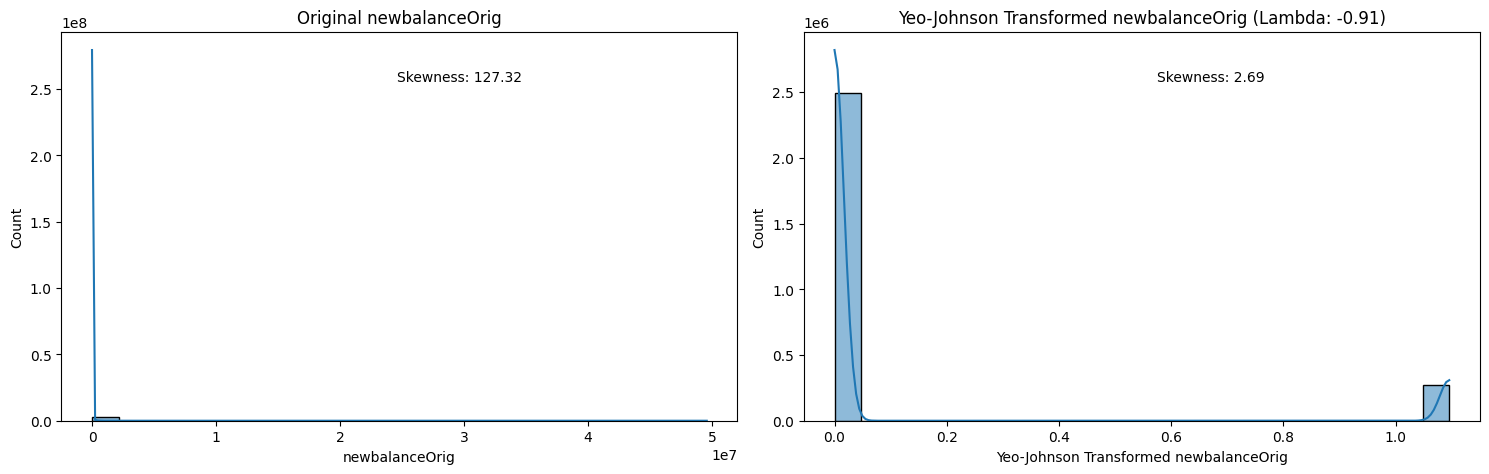

--------------------------------------------------
Plotting distribution for column: oldbalanceDest


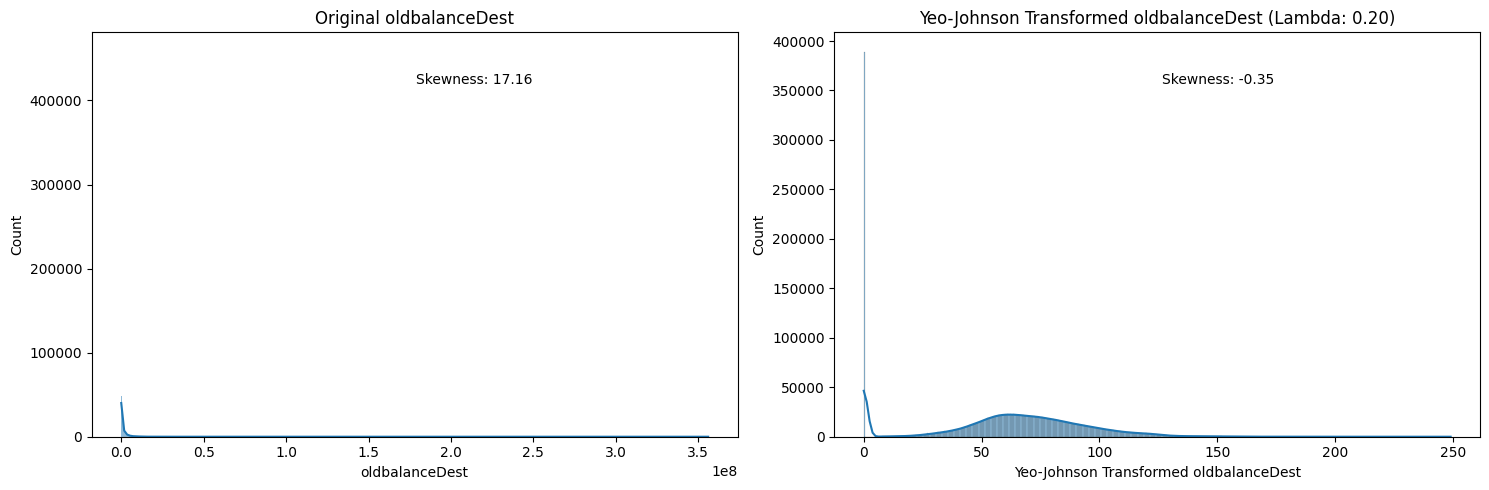

--------------------------------------------------
Plotting distribution for column: newbalanceDest


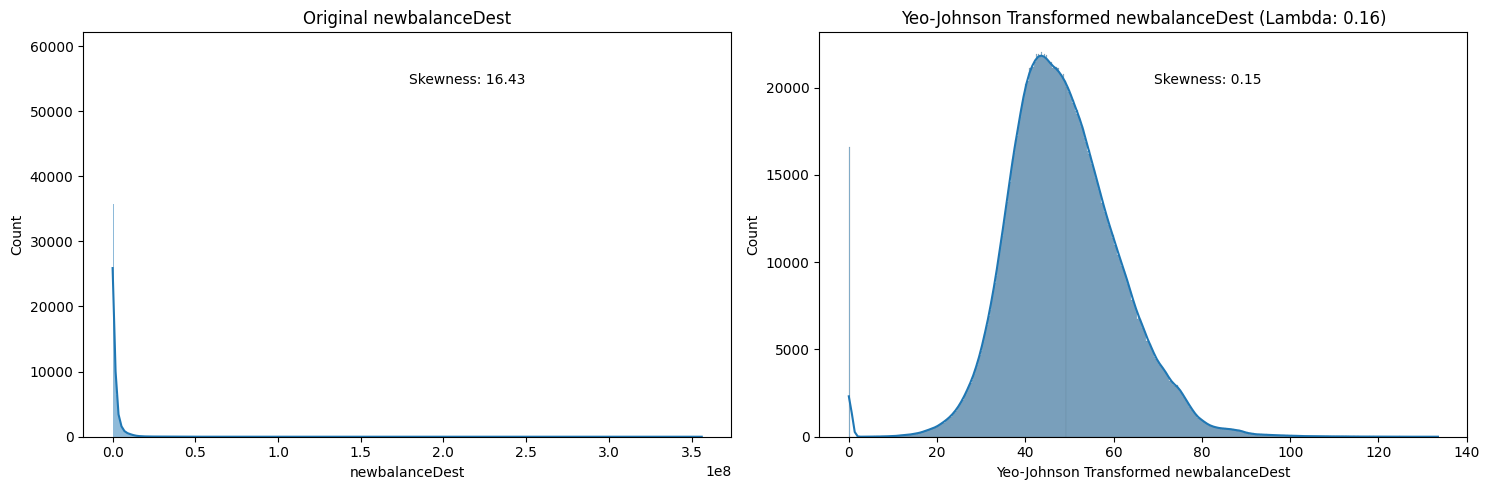

--------------------------------------------------
Plotting distribution for column: destDiff


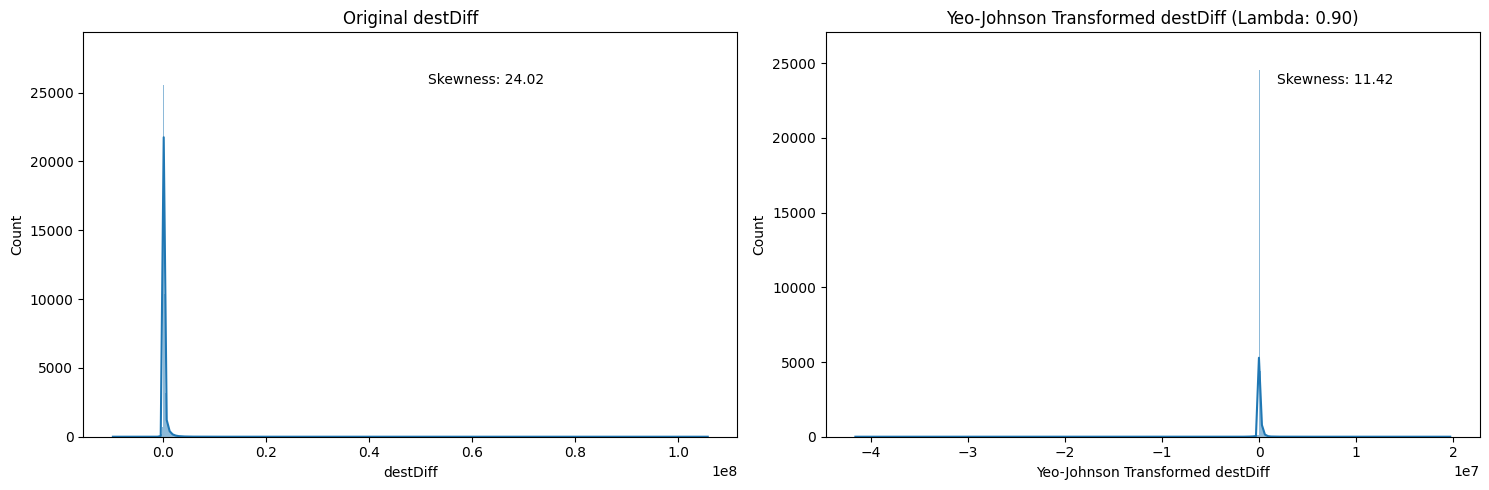

--------------------------------------------------
Plotting distribution for column: orgDiff


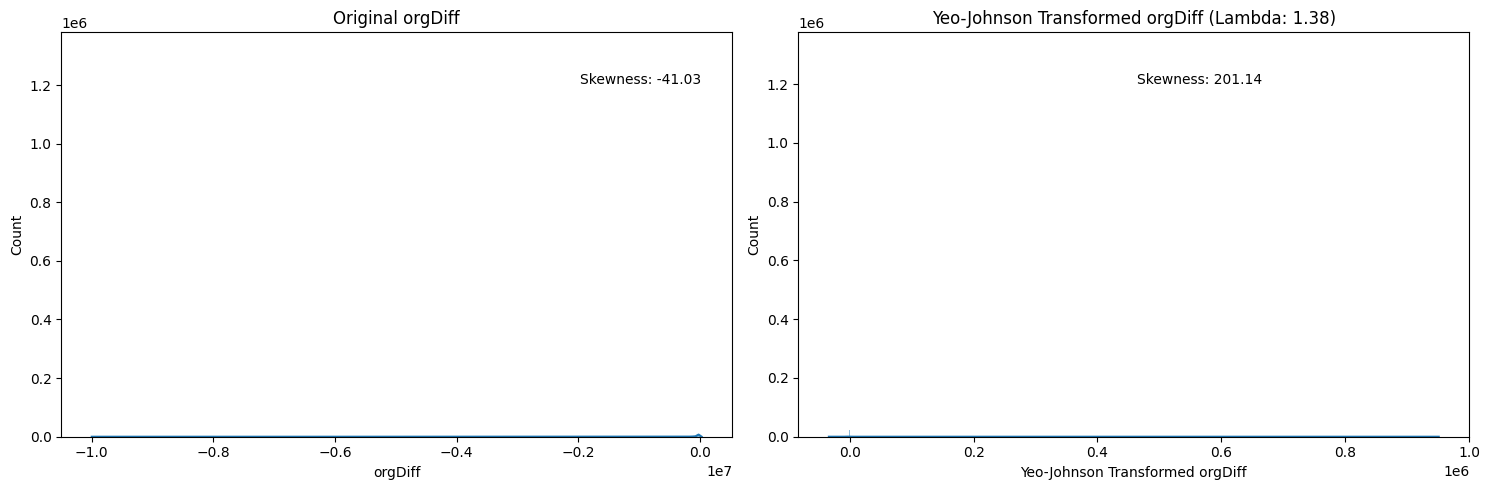

--------------------------------------------------


In [35]:
plot_yeojohnson_transformation(df, columns_to_transform, transformed_cols, lambda_values)

In [36]:
df = df.drop(columns=columns_to_transform)
df.head()

,isFraud,destGroup,orgGroup,typeLabel,amount_yeojohnson,oldbalanceOrg_yeojohnson,newbalanceOrig_yeojohnson,oldbalanceDest_yeojohnson,newbalanceDest_yeojohnson,destDiff_yeojohnson,orgDiff_yeojohnson
0,1,0,0,1,6.863829,4.935684,0.0,0.000000,0.000000,0.000000,-38.573995
1,1,0,0,0,6.863829,4.935684,0.0,31.512813,0.000000,-50457.163407,-38.573995
2,0,1,0,0,24.702539,8.743900,0.0,22.469813,28.581080,18241.023704,-617.967547
3,0,0,0,1,24.484368,6.137151,0.0,31.930324,0.000000,-53712.359526,-91.150673
4,0,1,0,1,25.801888,8.458434,0.0,23.640979,58.738229,720188.141425,-498.654145


In [37]:
# Then scale the data
scaler = StandardScaler()
df[transformed_cols] = scaler.fit_transform(df[transformed_cols])
df.head()

,isFraud,destGroup,orgGroup,typeLabel,amount_yeojohnson,oldbalanceOrg_yeojohnson,newbalanceOrig_yeojohnson,oldbalanceDest_yeojohnson,newbalanceDest_yeojohnson,destDiff_yeojohnson,orgDiff_yeojohnson
0,1,0,0,1,-4.096788,0.039564,-0.331128,-1.873353,-3.863134,-0.345125,0.430766
1,1,0,0,0,-4.096788,0.039564,-0.331128,-0.917296,-3.863134,-0.524723,0.430766
2,0,1,0,0,0.287913,0.856874,-0.331128,-1.191649,-1.591587,-0.280197,-0.019385
3,0,0,0,1,0.234287,0.297420,-0.331128,-0.904629,-3.863134,-0.536309,0.389917
4,0,1,0,1,0.558130,0.795608,-0.331128,-1.156117,0.805223,2.218328,0.073314


Identifying the most important features based on different methods...

In [38]:
X = df.drop(columns='isFraud')
y = df['isFraud']

X_train, X_test_realDist, y_train, y_test_realDist = train_test_split(X, y, test_size=0.15, random_state=0, stratify=y)

# Undersample the training data
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=0, stratify=y_resampled)

In [39]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=0, class_weight='balanced')
rf_model.fit(X_train, y_train)

feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

sorted_feature_importances = feature_importances.sort_values(ascending=False)
print("Random Forest Feature Importances (with Undersampling):")
print(sorted_feature_importances)

Random Forest Feature Importances (with Undersampling):
orgDiff_yeojohnson           0.334431
oldbalanceOrg_yeojohnson     0.198345
newbalanceDest_yeojohnson    0.123017
destDiff_yeojohnson          0.101257
amount_yeojohnson            0.082829
newbalanceOrig_yeojohnson    0.067827
oldbalanceDest_yeojohnson    0.043667
destGroup                    0.034497
typeLabel                    0.014131
orgGroup                     0.000000
dtype: float64


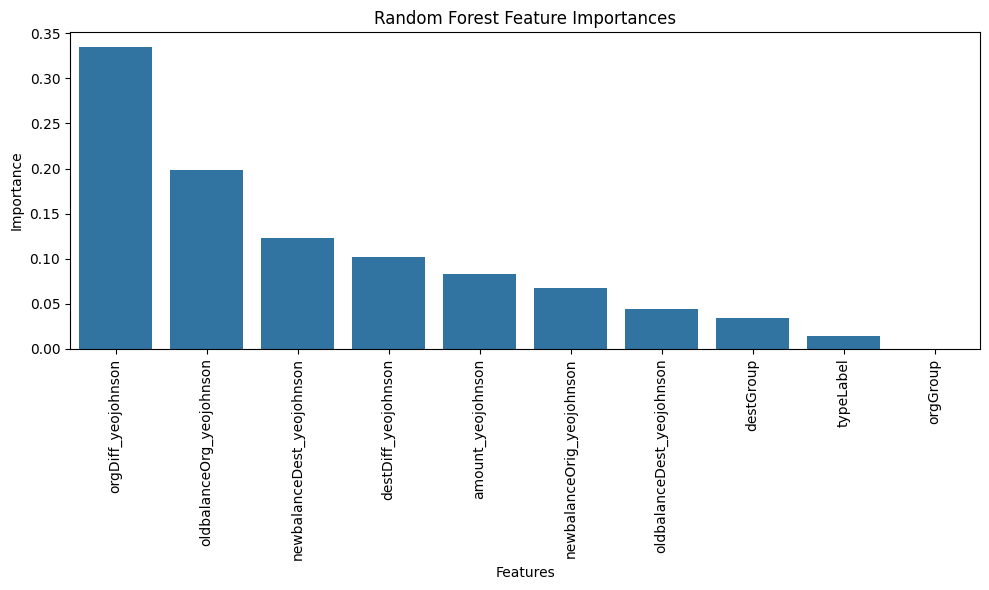

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances.index, y=sorted_feature_importances.values)
plt.xticks(rotation=90)
plt.title('Random Forest Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [41]:
threshold = 0.01
selected_features = sorted_feature_importances[sorted_feature_importances > threshold].index.tolist()

print("Selected features based on importance threshold:")
print(selected_features)

Selected features based on importance threshold:
['orgDiff_yeojohnson', 'oldbalanceOrg_yeojohnson', 'newbalanceDest_yeojohnson', 'destDiff_yeojohnson', 'amount_yeojohnson', 'newbalanceOrig_yeojohnson', 'oldbalanceDest_yeojohnson', 'destGroup', 'typeLabel']


In [42]:
# Calculate mutual information scores
# Using a small number of discrete features can improve performance for large datasets
# We'll treat all features as continuous for now, but consider discretizing if performance is an issue
mi_scores = mutual_info_classif(X, y, random_state=0)

# Create a pandas Series for better visualization and sorting
mi_series = pd.Series(mi_scores, index=X.columns)

sorted_mi_scores = mi_series.sort_values(ascending=False)

print("Mutual Information Scores:")
print(sorted_mi_scores)

Mutual Information Scores:
destGroup                    0.291193
newbalanceOrig_yeojohnson    0.176026
oldbalanceOrg_yeojohnson     0.147195
orgDiff_yeojohnson           0.062831
typeLabel                    0.052966
oldbalanceDest_yeojohnson    0.019629
destDiff_yeojohnson          0.008764
newbalanceDest_yeojohnson    0.005866
amount_yeojohnson            0.004343
orgGroup                     0.000026
dtype: float64


In [43]:
print("\nMutual Information Top Features:")
print(sorted_mi_scores.head(len(selected_features))) # Displaying the top features to match the number from RF


Mutual Information Top Features:
destGroup                    0.291193
newbalanceOrig_yeojohnson    0.176026
oldbalanceOrg_yeojohnson     0.147195
orgDiff_yeojohnson           0.062831
typeLabel                    0.052966
oldbalanceDest_yeojohnson    0.019629
destDiff_yeojohnson          0.008764
newbalanceDest_yeojohnson    0.005866
amount_yeojohnson            0.004343
dtype: float64


In [44]:
k_features = 8
select_k_best = SelectKBest(score_func=f_classif, k=k_features)

X_new = select_k_best.fit_transform(X, y)

# Get the indices of the selected features
selected_feature_indices = select_k_best.get_support(indices=True)

# Get the names of the selected features
selected_features_kb = X.columns[selected_feature_indices].tolist()

print(f"Top {k_features} features selected by SelectKBest (f_classif):")
print(selected_features_kb)

# You can also get the scores for each feature
feature_scores_kb = pd.Series(select_k_best.scores_, index=X.columns)
sorted_feature_scores_kb = feature_scores_kb.sort_values(ascending=False)

print("\nSelectKBest (f_classif) scores:")
print(sorted_feature_scores_kb)

Top 8 features selected by SelectKBest (f_classif):
['destGroup', 'typeLabel', 'amount_yeojohnson', 'oldbalanceOrg_yeojohnson', 'oldbalanceDest_yeojohnson', 'newbalanceDest_yeojohnson', 'destDiff_yeojohnson', 'orgDiff_yeojohnson']

SelectKBest (f_classif) scores:
orgDiff_yeojohnson           305067.157813
destGroup                    115926.712850
newbalanceDest_yeojohnson     28404.720846
oldbalanceOrg_yeojohnson      16223.297666
oldbalanceDest_yeojohnson     11778.421713
amount_yeojohnson              7364.720720
typeLabel                      4989.588344
destDiff_yeojohnson             910.320553
newbalanceOrig_yeojohnson       582.226845
orgGroup                          0.005947
dtype: float64


In [45]:
print("\nSelectKBest (f_classif) Top Features:")
print(selected_features_kb)


SelectKBest (f_classif) Top Features:
['destGroup', 'typeLabel', 'amount_yeojohnson', 'oldbalanceOrg_yeojohnson', 'oldbalanceDest_yeojohnson', 'newbalanceDest_yeojohnson', 'destDiff_yeojohnson', 'orgDiff_yeojohnson']


In [46]:
# Find features common to all three methods
common_features = list(set(selected_features) & set(sorted_mi_scores.head(len(selected_features)).index.tolist()) & set(selected_features_kb))

print("\nFeatures common to all three selection methods:")
print(common_features)


Features common to all three selection methods:
['oldbalanceOrg_yeojohnson', 'amount_yeojohnson', 'typeLabel', 'oldbalanceDest_yeojohnson', 'orgDiff_yeojohnson', 'destDiff_yeojohnson', 'newbalanceDest_yeojohnson', 'destGroup']


Selecting only those common features...

In [47]:
X_train, X_test = X_train[common_features], X_test[common_features]
X_test_realDist = X_test_realDist[common_features]
X_train.head()

,oldbalanceOrg_yeojohnson,amount_yeojohnson,typeLabel,oldbalanceDest_yeojohnson,orgDiff_yeojohnson,destDiff_yeojohnson,newbalanceDest_yeojohnson,destGroup
1016606,1.394056,0.497154,1,1.097316,-2.498158,-0.004130,1.154389,1
473151,0.912294,-0.446237,0,0.885476,-0.122917,-0.222002,0.825600,1
2537584,-1.019720,0.351218,0,-0.212319,0.460735,-0.051667,-0.405618,1
2770321,1.460999,1.058058,1,-1.873353,-3.860478,-0.345125,-3.863134,0
2635556,1.528895,1.459321,0,-0.072676,-5.127208,0.519889,0.169419,1


###Modelling

In [48]:
lr = LogisticRegression(solver="saga", class_weight='balanced', random_state=0)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'max_iter': [200, 300]
}

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

best_lr_model = grid_search.best_estimator_
lr_pred = best_lr_model.predict(X_test)

print("Best Logistic Regression Model:", best_lr_model)
print("Logistic Regression Metrics:")
print(classification_report(y_test, lr_pred))

roc_auc_score_lr = roc_auc_score(y_test, lr_pred)
print("ROC AUC Score (Logistic Regression):", roc_auc_score_lr)

Best Logistic Regression Model: LogisticRegression(C=0.1, class_weight='balanced', max_iter=200, random_state=0,
                   solver='saga')
Logistic Regression Metrics:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1048
           1       0.92      0.94      0.93      1047

    accuracy                           0.93      2095
   macro avg       0.93      0.93      0.93      2095
weighted avg       0.93      0.93      0.93      2095

ROC AUC Score (Logistic Regression): 0.9288853284921659


In [49]:
y_scores_lr = best_lr_model.predict_proba(X_test)[:, 1]

lr_precisions, lr_recalls, lr_thresholds = precision_recall_curve(y_test, y_scores_lr)

# Compute F1 for each threshold
f1_scores = 2 * (lr_precisions * lr_recalls) / (lr_precisions + lr_recalls)
best_thresh_lr = lr_thresholds[np.argmax(f1_scores)]

print(f"Best threshold for F1 (Logistic Regression): {best_thresh_lr:.3f}")

y_pred_opt_lr = (y_scores_lr >= best_thresh_lr).astype(int)

print("\nLogistic Regression with Optimized Threshold Metrics:")
print(classification_report(y_test, y_pred_opt_lr, target_names=["non-fraud", "fraud"]))

roc_auc_score_lr_opt = roc_auc_score(y_test, y_pred_opt_lr)
print("ROC AUC Score (Logistic Regression with Optimized Threshold):", roc_auc_score_lr_opt)

Best threshold for F1 (Logistic Regression): 0.508

Logistic Regression with Optimized Threshold Metrics:
              precision    recall  f1-score   support

   non-fraud       0.94      0.92      0.93      1048
       fraud       0.92      0.94      0.93      1047

    accuracy                           0.93      2095
   macro avg       0.93      0.93      0.93      2095
weighted avg       0.93      0.93      0.93      2095

ROC AUC Score (Logistic Regression with Optimized Threshold): 0.9293624277288072


In [50]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=0)

param_grid = {
    'max_depth': [2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

best_dt_model = grid_search.best_estimator_
dt_pred = best_dt_model.predict(X_test)

print("Best Decision Tree Model:", best_dt_model)
print("Decision Tree Metrics:")
print(classification_report(y_test, dt_pred))

roc_auc_score_dt = roc_auc_score(y_test, dt_pred)
print("ROC AUC Score (Decision Tree):", roc_auc_score_dt)

Best Decision Tree Model: DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, random_state=0)
Decision Tree Metrics:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1048
           1       0.96      0.99      0.98      1047

    accuracy                           0.98      2095
   macro avg       0.98      0.98      0.98      2095
weighted avg       0.98      0.98      0.98      2095

ROC AUC Score (Decision Tree): 0.9780497896571083


In [51]:
y_scores_dt = best_dt_model.predict_proba(X_test)[:, 1]

dt_precisions, dt_recalls, dt_thresholds = precision_recall_curve(y_test, y_scores_dt)

f1_scores = 2 * (dt_precisions * dt_recalls) / (dt_precisions + dt_recalls)
best_thresh_dt = dt_thresholds[np.argmax(f1_scores)]

print(f"Best threshold for F1 (Decision Tree): {best_thresh_dt:.3f}")

y_pred_opt_dt = (y_scores_dt >= best_thresh_dt).astype(int)

print("\nDecision Tree with Optimized Threshold Metrics:")
print(classification_report(y_test, y_pred_opt_dt, target_names=["non-fraud", "fraud"]))

roc_auc_score_dt_opt = roc_auc_score(y_test, y_pred_opt_dt)
print("ROC AUC Score (Decision Tree with Optimized Threshold):", roc_auc_score_dt_opt)

Best threshold for F1 (Decision Tree): 0.695

Decision Tree with Optimized Threshold Metrics:
              precision    recall  f1-score   support

   non-fraud       0.99      0.96      0.98      1048
       fraud       0.96      0.99      0.98      1047

    accuracy                           0.98      2095
   macro avg       0.98      0.98      0.98      2095
weighted avg       0.98      0.98      0.98      2095

ROC AUC Score (Decision Tree with Optimized Threshold): 0.9780497896571083


In [52]:
rf = RandomForestClassifier(class_weight='balanced', random_state=0)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
rf_pred = best_rf_model.predict(X_test)

print("Best Random Forest Model:", best_rf_model)
print("Random Forest Metrics:")
print(classification_report(y_test, rf_pred))

roc_auc_score_rf = roc_auc_score(y_test, rf_pred)
print("ROC AUC Score (Random Forest):", roc_auc_score_rf)

Best Random Forest Model: RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_split=10, n_estimators=200, random_state=0)
Random Forest Metrics:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1048
           1       0.97      0.99      0.98      1047

    accuracy                           0.98      2095
   macro avg       0.98      0.98      0.98      2095
weighted avg       0.98      0.98      0.98      2095

ROC AUC Score (Random Forest): 0.9780475112462361


In [53]:
y_scores_rf = best_rf_model.predict_proba(X_test)[:, 1]

rf_precisions, rf_recalls, rf_thresholds = precision_recall_curve(y_test, y_scores_rf)

f1_scores = 2 * (rf_precisions * rf_recalls) / (rf_precisions + rf_recalls)
best_thresh_rf = rf_thresholds[np.argmax(f1_scores)]

print(f"Best threshold for F1 (Random Forest): {best_thresh_rf:.3f}")

y_pred_opt_rf = (y_scores_rf >= best_thresh_rf).astype(int)

print("\nRandom Forest with Optimized Threshold Metrics:")
print(classification_report(y_test, y_pred_opt_rf, target_names=["non-fraud", "fraud"]))

roc_auc_score_rf_opt = roc_auc_score(y_test, y_pred_opt_rf)
print("ROC AUC Score (Random Forest with Optimized Threshold):", roc_auc_score_rf_opt)

Best threshold for F1 (Random Forest): 0.594

Random Forest with Optimized Threshold Metrics:
              precision    recall  f1-score   support

   non-fraud       0.98      0.98      0.98      1048
       fraud       0.98      0.98      0.98      1047

    accuracy                           0.98      2095
   macro avg       0.98      0.98      0.98      2095
weighted avg       0.98      0.98      0.98      2095

ROC AUC Score (Random Forest with Optimized Threshold): 0.9813858388562012


In [54]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

best_knn_model = grid_search.best_estimator_
knn_pred = best_knn_model.predict(X_test)

print("Best KNN Model:", best_knn_model)
print("KNN Metrics:")
print(classification_report(y_test, knn_pred))

roc_auc_score_knn = roc_auc_score(y_test, knn_pred)
print("ROC AUC Score (KNN):", roc_auc_score_knn)

Best KNN Model: KNeighborsClassifier(n_neighbors=3, weights='distance')
KNN Metrics:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1048
           1       0.93      0.98      0.96      1047

    accuracy                           0.96      2095
   macro avg       0.96      0.96      0.96      2095
weighted avg       0.96      0.96      0.96      2095

ROC AUC Score (KNN): 0.9560982122676933


In [55]:
y_scores_knn = best_knn_model.predict_proba(X_test)[:, 1]

knn_precisions, knn_recalls, knn_thresholds = precision_recall_curve(y_test, y_scores_knn)

f1_scores = 2 * (knn_precisions * knn_recalls) / (knn_precisions + knn_recalls)
best_thresh_knn = knn_thresholds[np.argmax(f1_scores)]

print(f"Best threshold for F1 (KNN): {best_thresh_knn:.3f}")

y_pred_opt_knn = (y_scores_knn >= best_thresh_knn).astype(int)

print("\nKNN with Optimized Threshold Metrics:")
print(classification_report(y_test, y_pred_opt_knn))

roc_auc_score_knn_opt = roc_auc_score(y_test, y_pred_opt_knn)
print("ROC AUC Score (KNN with Optimized Threshold):", roc_auc_score_knn_opt)

Best threshold for F1 (KNN): 0.636

KNN with Optimized Threshold Metrics:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1048
           1       0.95      0.97      0.96      1047

    accuracy                           0.96      2095
   macro avg       0.96      0.96      0.96      2095
weighted avg       0.96      0.96      0.96      2095

ROC AUC Score (KNN with Optimized Threshold): 0.9603884599400687


In [56]:
svc = SVC(kernel="rbf", class_weight='balanced', random_state=0)

param_grid = {
    'C': [0.1, 1, 2, 5, 10],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

best_svc_model = grid_search.best_estimator_
svc_pred = best_svc_model.predict(X_test)

print("Best SVC Model:", best_svc_model)
print("SVC Metrics:")
print(classification_report(y_test, svc_pred))

roc_auc_score_svc = roc_auc_score(y_test, svc_pred)
print("ROC AUC Score (SVC):", roc_auc_score_svc)

Best SVC Model: SVC(C=10, class_weight='balanced', gamma='auto', random_state=0)
SVC Metrics:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1048
           1       0.96      0.99      0.98      1047

    accuracy                           0.98      2095
   macro avg       0.98      0.98      0.98      2095
weighted avg       0.98      0.98      0.98      2095

ROC AUC Score (SVC): 0.9766189476293591


In [57]:
nb = GaussianNB()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 0.01]
}

grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

best_nb_model = grid_search.best_estimator_
nb_pred = best_nb_model.predict(X_test)

print("Best Naive Bayes Model:", best_nb_model)
print("Naive Bayes Metrics:")
print(classification_report(y_test, nb_pred))

roc_auc_score_nb = roc_auc_score(y_test, nb_pred)
print("ROC AUC Score (Naive Bayes):", roc_auc_score_nb)

Best Naive Bayes Model: GaussianNB(var_smoothing=0.001)
Naive Bayes Metrics:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1048
           1       0.95      0.84      0.90      1047

    accuracy                           0.90      2095
   macro avg       0.91      0.90      0.90      2095
weighted avg       0.91      0.90      0.90      2095

ROC AUC Score (Naive Bayes): 0.9021203802941155


In [58]:
y_scores_nb = best_nb_model.predict_proba(X_test)[:, 1]

nb_precisions, nb_recalls, nb_thresholds = precision_recall_curve(y_test, y_scores_nb)

f1_scores = 2 * (nb_precisions * nb_recalls) / (nb_precisions + nb_recalls)
best_thresh_nb = nb_thresholds[np.argmax(f1_scores)]

print(f"Best threshold for F1 (Naive Bayes): {best_thresh_nb:.3f}")

y_pred_opt_nb = (y_scores_nb >= best_thresh_nb).astype(int)

print("\nNaive Bayes with Optimized Threshold Metrics:")
print(classification_report(y_test, y_pred_opt_nb))

roc_auc_score_nb_opt = roc_auc_score(y_test, y_pred_opt_nb)
print("ROC AUC Score (Naive Bayes with Optimized Threshold):", roc_auc_score_nb_opt)

Best threshold for F1 (Naive Bayes): 0.103

Naive Bayes with Optimized Threshold Metrics:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1048
           1       0.91      0.90      0.90      1047

    accuracy                           0.90      2095
   macro avg       0.90      0.90      0.90      2095
weighted avg       0.90      0.90      0.90      2095

ROC AUC Score (Naive Bayes with Optimized Threshold): 0.904055206806798


In [59]:
xgb = XGBClassifier(random_state=0)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

best_xgb_model = grid_search.best_estimator_
xgb_pred = best_xgb_model.predict(X_test)

print("Best XGBoost Model:", best_xgb_model)
print("XGBoost Metrics:")
print(classification_report(y_test, xgb_pred))

roc_auc_score_xgb = roc_auc_score(y_test, xgb_pred)
print("ROC AUC Score (XGBoost):", roc_auc_score_xgb)

Best XGBoost Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)
XGBoost Metrics:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1048
           1       0.98      0.99      0.98      1047

    accuracy                           0.98

In [60]:
y_scores_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

xgb_precisions, xgb_recalls, xgb_thresholds = precision_recall_curve(y_test, y_scores_xgb)

f1_scores = 2 * (xgb_precisions * xgb_recalls) / (xgb_precisions + xgb_recalls)
best_thresh_xgb = xgb_thresholds[np.argmax(f1_scores)]

print(f"Best threshold for F1 (XGBoost): {best_thresh_xgb:.3f}")

y_pred_opt_xgb = (y_scores_xgb >= best_thresh_xgb).astype(int)

print("\nXGBoost with Optimized Threshold Metrics:")
print(classification_report(y_test, y_pred_opt_xgb))

roc_auc_score_xgb_opt = roc_auc_score(y_test, y_pred_opt_xgb)
print("ROC AUC Score (XGBoost with Optimized Threshold):", roc_auc_score_xgb_opt)

Best threshold for F1 (XGBoost): 0.601

XGBoost with Optimized Threshold Metrics:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1048
           1       0.98      0.99      0.99      1047

    accuracy                           0.99      2095
   macro avg       0.99      0.99      0.99      2095
weighted avg       0.99      0.99      0.99      2095

ROC AUC Score (XGBoost with Optimized Threshold): 0.9856838331255423


[I 2025-10-26 10:31:32,722] A new study created in memory with name: no-name-27958cb3-b32d-4f85-b173-957533282e1b
[I 2025-10-26 10:31:50,132] Trial 0 finished with value: 0.9121621251106262 and parameters: {'units1': 205, 'dropout1': 0.3152197954158315, 'units2': 115, 'dropout2': 0.30826746970652197, 'lr': 1.1564207301837515e-05, 'batch_size': 187}. Best is trial 0 with value: 0.9121621251106262.
[I 2025-10-26 10:32:00,180] Trial 1 finished with value: 0.9826014637947083 and parameters: {'units1': 177, 'dropout1': 0.3856641198591756, 'units2': 54, 'dropout2': 0.10530873413090908, 'lr': 0.0029815734094722616, 'batch_size': 203}. Best is trial 1 with value: 0.9826014637947083.
[I 2025-10-26 10:32:15,793] Trial 2 finished with value: 0.9329982995986938 and parameters: {'units1': 183, 'dropout1': 0.4492507648728677, 'units2': 111, 'dropout2': 0.25116032290231743, 'lr': 7.176844176960356e-05, 'batch_size': 234}. Best is trial 1 with value: 0.9826014637947083.
[I 2025-10-26 10:32:27,166] Tri

Best parameters found: {'units1': 186, 'dropout1': 0.3368038061614301, 'units2': 52, 'dropout2': 0.325891195179783, 'lr': 0.004202315942066566, 'batch_size': 209}
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Neural Network Metrics:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1048
           1       0.96      0.99      0.98      1047

    accuracy                           0.97      2095
   macro avg       0.98      0.97      0.97      2095
weighted avg       0.98      0.97      0.97      2095

ROC AUC Score (Neural Network): 0.9747105506827942


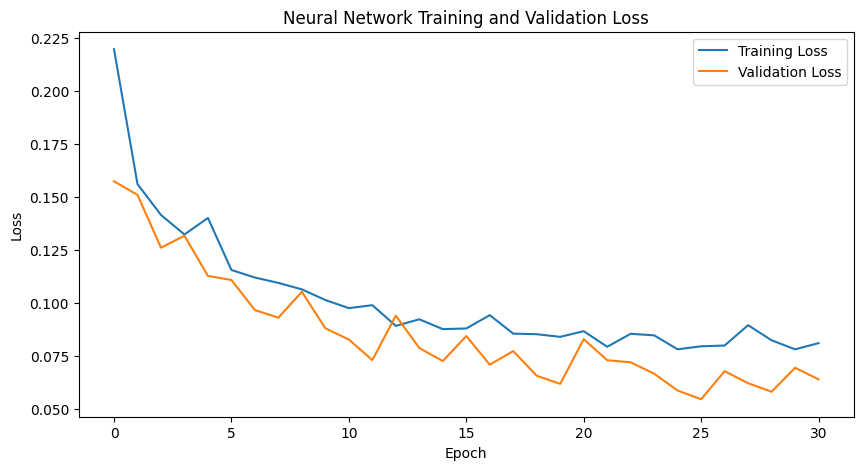

In [61]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train, y_train, test_size=0.1, random_state=0, stratify=y_train)

def objective(trial):
    model = Sequential([
        Dense(trial.suggest_int('units1', 32, 256), activation='relu', input_shape=(X_train_nn.shape[1],)),
        Dropout(trial.suggest_float('dropout1', 0.0, 0.5)),
        Dense(trial.suggest_int('units2', 16, 128), activation='relu'),
        Dropout(trial.suggest_float('dropout2', 0.0, 0.5)),
        Dense(1, activation='sigmoid')
    ])

    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    optimizer = keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[keras.metrics.F1Score(threshold=0.5, name='f1_score')])

    early_stopping_tune = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train_nn, y_train_nn,
                        epochs=50,
                        batch_size=trial.suggest_int('batch_size', 32, 256),
                        validation_data=(X_val_nn, y_val_nn),
                        callbacks=[early_stopping_tune],
                        verbose=0)

    return history.history['val_f1_score'][-1]


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)


print("Best parameters found:", study.best_params)
best_params = study.best_params

nn = Sequential([
    Dense(best_params['units1'], activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dropout(best_params['dropout1']),
    Dense(best_params['units2'], activation='relu'),
    Dropout(best_params['dropout2']),
    Dense(1, activation='sigmoid')
])

nn.compile(optimizer=keras.optimizers.Adam(learning_rate=best_params['lr']),
           loss='binary_crossentropy',
           metrics=[keras.metrics.F1Score(threshold=0.5, name='f1_score')])

early_stopping_final = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = nn.fit(X_train_nn, y_train_nn,
                 epochs=100,
                 batch_size=best_params['batch_size'],
                 validation_data=(X_val_nn, y_val_nn),
                 callbacks=[early_stopping_final],
                 verbose=0)


nn_pred = nn.predict(X_test)
nn_pred = (nn_pred > 0.5).astype(int)

print("Neural Network Metrics:")
print(classification_report(y_test, nn_pred))

roc_auc_score_nn = roc_auc_score(y_test, nn_pred)
print("ROC AUC Score (Neural Network):", roc_auc_score_nn)

plt.figure(figsize=(10, 5))
sns.lineplot(x=history.epoch, y=history.history['loss'], label='Training Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
y_scores_nn = nn.predict(X_test)

nn_precisions, nn_recalls, nn_thresholds = precision_recall_curve(y_test, y_scores_nn)

f1_scores = 2 * (nn_precisions * nn_recalls) / (nn_precisions + nn_recalls + 1e-1)
best_thresh_nn = nn_thresholds[np.argmax(f1_scores)]

print(f"Best threshold for F1 (Neural Network): {best_thresh_nn:.3f}")

y_pred_opt_nn = (y_scores_nn >= best_thresh_nn).astype(int)

print("\nNeural Network with Optimized Threshold Metrics:")
print(classification_report(y_test, y_pred_opt_nn))

roc_auc_score_nn_opt = roc_auc_score(y_test, y_pred_opt_nn)
print("ROC AUC Score (Neural Network with Optimized Threshold):", roc_auc_score_nn_opt)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold for F1 (Neural Network): 0.744

Neural Network with Optimized Threshold Metrics:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1048
           1       0.98      0.99      0.98      1047

    accuracy                           0.98      2095
   macro avg       0.98      0.98      0.98      2095
weighted avg       0.98      0.98      0.98      2095

ROC AUC Score (Neural Network with Optimized Threshold): 0.9842520797334442


In [63]:
# Comparing different metrics (recall, precision, f1, auc)
metrics = {
    'Logistic Regression': [roc_auc_score_lr, classification_report(y_test, lr_pred, output_dict=True)['weighted avg']['recall'],
                            classification_report(y_test, lr_pred, output_dict=True)['weighted avg']['precision'],
                            classification_report(y_test, lr_pred, output_dict=True)['weighted avg']['f1-score']],
    'Decision Tree': [roc_auc_score_dt, classification_report(y_test, dt_pred, output_dict=True)['weighted avg']['recall'],
                      classification_report(y_test, dt_pred, output_dict=True)['weighted avg']['precision'],
                      classification_report(y_test, dt_pred, output_dict=True)['weighted avg']['f1-score']],
    'Random Forest': [roc_auc_score_rf, classification_report(y_test, rf_pred, output_dict=True)['weighted avg']['recall'],
                      classification_report(y_test, rf_pred, output_dict=True)['weighted avg']['precision'],
                      classification_report(y_test, rf_pred, output_dict=True)['weighted avg']['f1-score']],
    'KNN': [roc_auc_score_knn, classification_report(y_test, knn_pred, output_dict=True)['weighted avg']['recall'],
            classification_report(y_test, knn_pred, output_dict=True)['weighted avg']['precision'],
            classification_report(y_test, knn_pred, output_dict=True)['weighted avg']['f1-score']],
    'SVC': [roc_auc_score_svc, classification_report(y_test, svc_pred, output_dict=True)['weighted avg']['recall'],
            classification_report(y_test, svc_pred, output_dict=True)['weighted avg']['precision'],
            classification_report(y_test, svc_pred, output_dict=True)['weighted avg']['f1-score']],
    'Naive Bayes': [roc_auc_score_nb, classification_report(y_test, nb_pred, output_dict=True)['weighted avg']['recall'],
                    classification_report(y_test, nb_pred, output_dict=True)['weighted avg']['precision'], classification_report(y_test, nb_pred, output_dict=True)['weighted avg']['f1-score']],
    'XGBoost': [roc_auc_score_xgb, classification_report(y_test, xgb_pred, output_dict=True)['weighted avg']['recall'],
                classification_report(y_test, xgb_pred, output_dict=True)['weighted avg']['precision'],
                classification_report(y_test, xgb_pred, output_dict=True)['weighted avg']['f1-score']],
    'Neural Network': [roc_auc_score_nn, classification_report(y_test, nn_pred, output_dict=True)['weighted avg']['recall'],
                       classification_report(y_test, nn_pred, output_dict=True)['weighted avg']['precision'],
                       classification_report(y_test, nn_pred, output_dict=True)['weighted avg']['f1-score']]
}

metrics_df = pd.DataFrame(metrics, index=['ROC AUC', 'Recall', 'Precision', 'F1 Score'])
metrics_df

,Logistic Regression,Decision Tree,Random Forest,KNN,SVC,Naive Bayes,XGBoost,Neural Network
ROC AUC,0.928885,0.978050,0.978048,0.956098,0.976619,0.902120,0.984730,0.974711
Recall,0.928878,0.978043,0.978043,0.956086,0.976611,0.902148,0.984726,0.974702
Precision,0.929255,0.978436,0.978217,0.957302,0.977144,0.907582,0.984902,0.975361
F1 Score,0.928863,0.978039,0.978041,0.956057,0.976605,0.901818,0.984724,0.974693


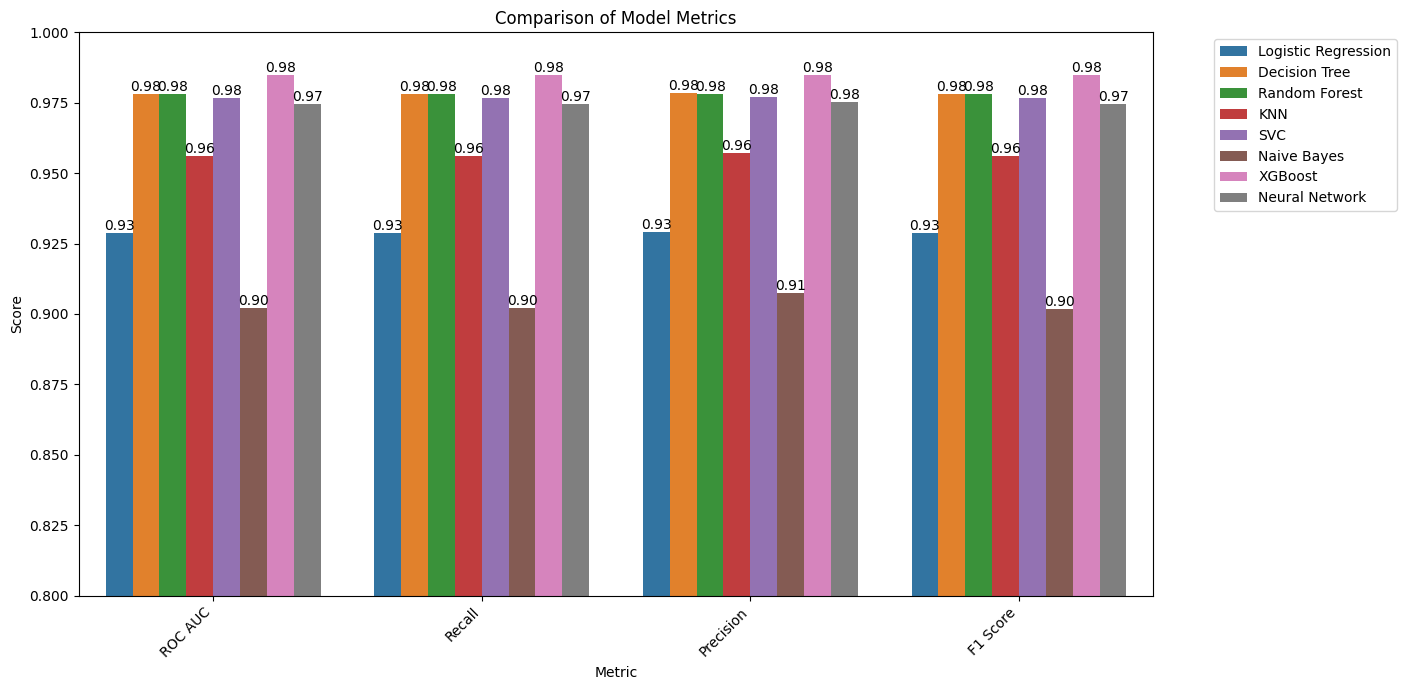

In [64]:
# Plotting the metrics for visual comparison
metrics_df_melted = metrics_df.reset_index().melt(id_vars='index', var_name='Model', value_name='Score')

plt.figure(figsize=(14, 7))
ax = sns.barplot(x='index', y='Score', hue='Model', data=metrics_df_melted)
plt.title('Comparison of Model Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

plt.ylim(0.8, 1.0)
plt.show()

In [65]:
prob_metrics = {
    'Logistic Regression': [roc_auc_score_lr_opt, classification_report(y_test, y_pred_opt_lr, output_dict=True)['weighted avg']['recall'],
                            classification_report(y_test, y_pred_opt_lr, output_dict=True)['weighted avg']['precision'],
                            classification_report(y_test, y_pred_opt_lr, output_dict=True)['weighted avg']['f1-score']],
    'Decision Tree': [roc_auc_score_dt_opt, classification_report(y_test, y_pred_opt_dt, output_dict=True)['weighted avg']['recall'],
                      classification_report(y_test, y_pred_opt_dt, output_dict=True)['weighted avg']['precision'],
                      classification_report(y_test, y_pred_opt_dt, output_dict=True)['weighted avg']['f1-score']],
    'Random Forest': [roc_auc_score_rf_opt, classification_report(y_test, y_pred_opt_rf, output_dict=True)['weighted avg']['recall'],
                      classification_report(y_test, y_pred_opt_rf, output_dict=True)['weighted avg']['precision'],
                      classification_report(y_test, y_pred_opt_rf, output_dict=True)['weighted avg']['f1-score']],
    'KNN': [roc_auc_score_knn_opt, classification_report(y_test, y_pred_opt_knn, output_dict=True)['weighted avg']['recall'],
            classification_report(y_test, y_pred_opt_knn, output_dict=True)['weighted avg']['precision'],
            classification_report(y_test, y_pred_opt_knn, output_dict=True)['weighted avg']['f1-score']],
    'Naive Bayes': [roc_auc_score_nb_opt, classification_report(y_test, y_pred_opt_nb, output_dict=True)['weighted avg']['recall'],
                    classification_report(y_test, y_pred_opt_nb, output_dict=True)['weighted avg']['precision'], classification_report(y_test, y_pred_opt_nb, output_dict=True)['weighted avg']['f1-score']],
    'XGBoost': [roc_auc_score_xgb_opt, classification_report(y_test, y_pred_opt_xgb, output_dict=True)['weighted avg']['recall'],
                classification_report(y_test, y_pred_opt_xgb, output_dict=True)['weighted avg']['precision'],
                classification_report(y_test, y_pred_opt_xgb, output_dict=True)['weighted avg']['f1-score']],
    'Neural Network': [roc_auc_score_nn_opt, classification_report(y_test, y_pred_opt_nn, output_dict=True)['weighted avg']['recall'],
                       classification_report(y_test, y_pred_opt_nn, output_dict=True)['weighted avg']['precision'], classification_report(y_test, y_pred_opt_nn, output_dict=True)['weighted avg']['f1-score']]
}

prob_metrics_df = pd.DataFrame(prob_metrics, index=['ROC AUC', 'Recall', 'Precision', 'F1 Score'])
prob_metrics_df

,Logistic Regression,Decision Tree,Random Forest,KNN,Naive Bayes,XGBoost,Neural Network
ROC AUC,0.929362,0.978050,0.981386,0.960388,0.904055,0.985684,0.984252
Recall,0.929356,0.978043,0.981384,0.960382,0.904057,0.985680,0.984248
Precision,0.929709,0.978436,0.981406,0.960736,0.904087,0.985794,0.984376
F1 Score,0.929342,0.978039,0.981384,0.960375,0.904055,0.985679,0.984247


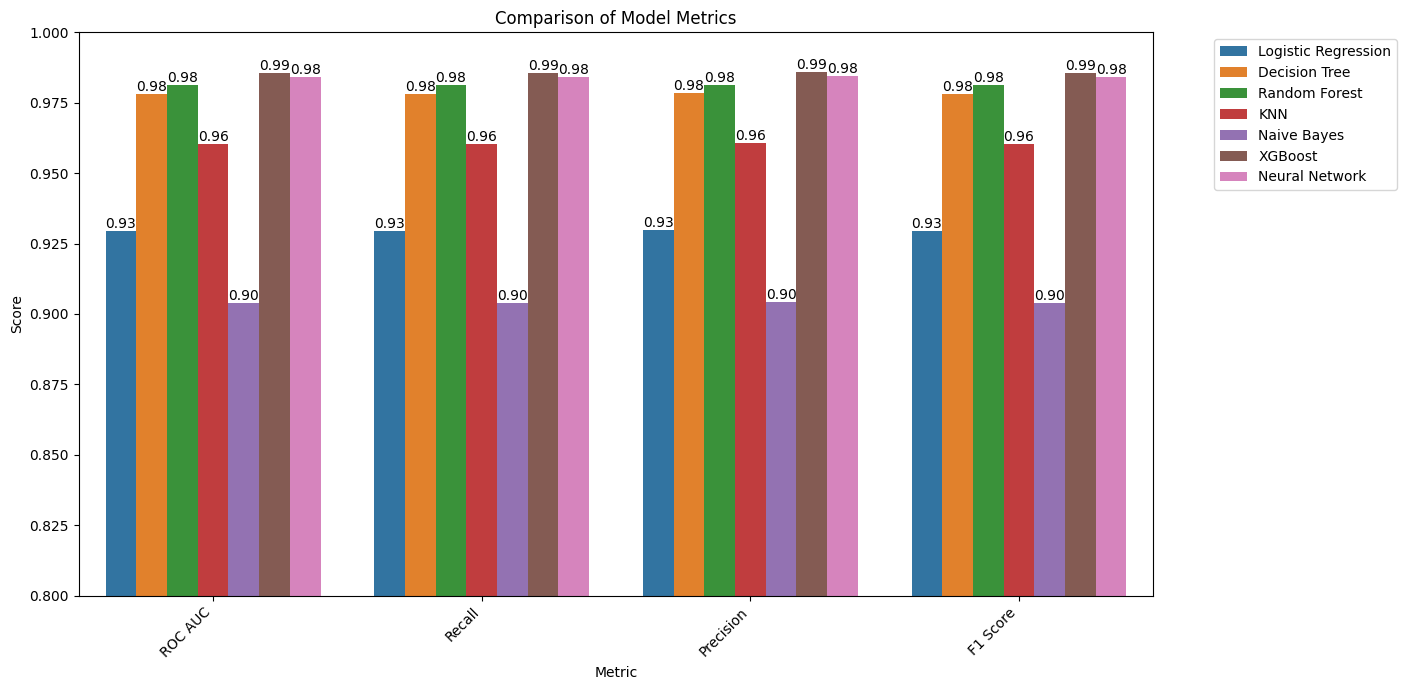

In [66]:
prob_metrics_df_melted = prob_metrics_df.reset_index().melt(id_vars='index', var_name='Model', value_name='Score')

plt.figure(figsize=(14, 7))
ax = sns.barplot(x='index', y='Score', hue='Model', data=prob_metrics_df_melted)
plt.title('Comparison of Model Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

plt.ylim(0.8, 1.0)
plt.show()

##Testing models based on holdout data with original distribution

In [67]:
models = {
    'Logistic Regression': best_lr_model,
    'Decision Tree': best_dt_model,
    'Random Forest': best_rf_model,
    'KNN': best_knn_model,
    'SVC': best_svc_model,
    'Naive Bayes': best_nb_model,
    'XGBoost': best_xgb_model,
    'Neural Network': history.model
}

thresholds = {
    'Logistic Regression': best_thresh_lr,
    'Decision Tree': best_thresh_dt,
    'Random Forest': best_thresh_rf,
    'KNN': best_thresh_knn,
    'Naive Bayes': best_thresh_nb,
    'XGBoost': best_thresh_xgb,
    'Neural Network': best_thresh_nn
}

In [68]:
for model_name, model in models.items():
    print(f"Model: {model_name}")
    if model_name in thresholds:
        if model_name == 'Neural Network':
            y_scores = model.predict(X_test_realDist)
        else:
            y_scores = model.predict_proba(X_test_realDist)[:, 1]
        temp_pred = (y_scores >= thresholds[model_name]).astype(int)
    else: # For models like SVC that don't have predict_proba or optimized threshold
        temp_pred = model.predict(X_test_realDist)

    print(f"ROC AUC Score: {roc_auc_score(y_test_realDist, temp_pred)}")
    print(classification_report(y_test_realDist, temp_pred))
    print("-"*75)

Model: Logistic Regression
ROC AUC Score: 0.9226297713943431
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    414330
           1       0.03      0.93      0.06      1232

    accuracy                           0.92    415562
   macro avg       0.52      0.92      0.51    415562
weighted avg       1.00      0.92      0.95    415562

---------------------------------------------------------------------------
Model: Decision Tree
ROC AUC Score: 0.9765191009362322
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    414330
           1       0.07      0.99      0.14      1232

    accuracy                           0.96    415562
   macro avg       0.54      0.98      0.56    415562
weighted avg       1.00      0.96      0.98    415562

---------------------------------------------------------------------------
Model: Random Forest
ROC AUC Score: 0.9785160406834253
              precision

In [70]:
best_model_name = prob_metrics_df.loc['F1 Score'].idxmax()
best_model = models[best_model_name]
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

Recalibrating model

In [71]:
X_test_real, X_valid_real, y_test_real, y_valid_real = train_test_split(X_test_realDist, y_test_realDist, test_size=0.1, random_state=0, stratify=y_test_realDist)

In [73]:
calibrated_model = CalibratedClassifierCV(best_model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_valid_real, y_valid_real)

# Get new calibrated probabilities
y_scores_cal = calibrated_model.predict_proba(X_test_real)[:, 1]
display(y_scores_cal)

precisions_best, recalls_best, thresholds_best = precision_recall_curve(y_test_real, y_scores_cal)

f1_scores_best = 2 * (precisions_best * recalls_best) / (precisions_best + recalls_best)
best_thresh_cal = thresholds_best[np.argmax(f1_scores_best)]

y_pred_cal = (y_scores_cal >= best_thresh_cal).astype(int)

print("Calibrated Model Metrics:")
print(classification_report(y_test_real, y_pred_cal))

roc_auc_score_cal = roc_auc_score(y_test_real, y_pred_cal)
print("ROC AUC Score (Calibrated Model):", roc_auc_score_cal)

array([2.68314361e-13, 2.05702982e-13, 1.94151898e-13, ...,
       1.95050278e-13, 1.94232903e-13, 5.13349060e-12])

Calibrated Model Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    372896
           1       0.96      0.73      0.83      1109

    accuracy                           1.00    374005
   macro avg       0.98      0.86      0.91    374005
weighted avg       1.00      1.00      1.00    374005

ROC AUC Score (Calibrated Model): 0.8633488752901087


In [75]:
from sklearn.metrics import average_precision_score

pr_auc = average_precision_score(y_test_real, y_scores_cal)
print("PR-AUC:", pr_auc)

PR-AUC: 0.8592636541328873


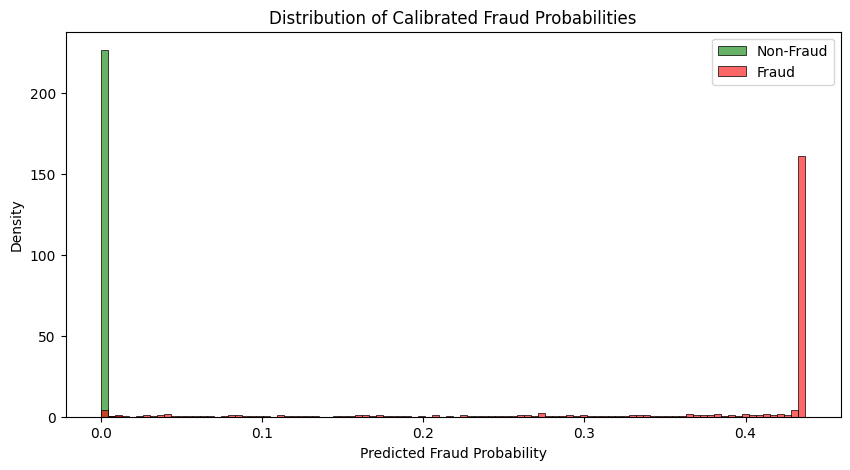

In [76]:
plt.figure(figsize=(10,5))
sns.histplot(y_scores_cal[y_test_real==0], color='green', label='Non-Fraud', bins=100, stat='density', alpha=0.6)
sns.histplot(y_scores_cal[y_test_real==1], color='red', label='Fraud', bins=100, stat='density', alpha=0.6)
plt.title("Distribution of Calibrated Fraud Probabilities")
plt.xlabel("Predicted Fraud Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

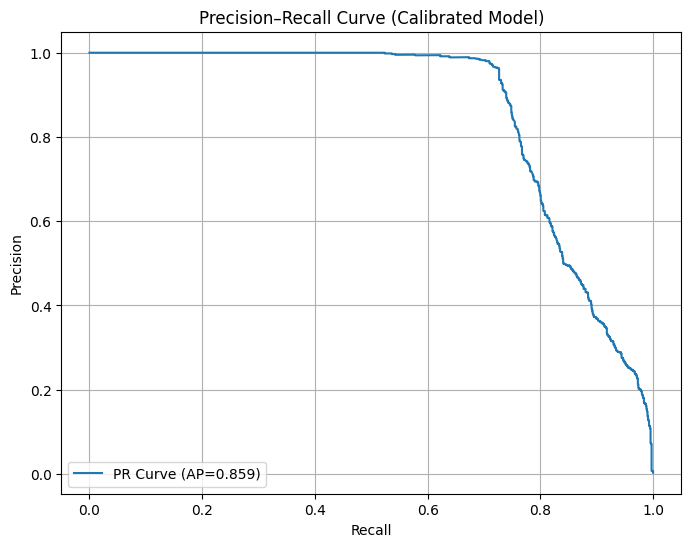

In [77]:
precisions, recalls, thresholds = precision_recall_curve(y_test_real, y_scores_cal)
ap_score = average_precision_score(y_test_real, y_scores_cal)

plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, label=f'PR Curve (AP={ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (Calibrated Model)')
plt.legend()
plt.grid(True)
plt.show()

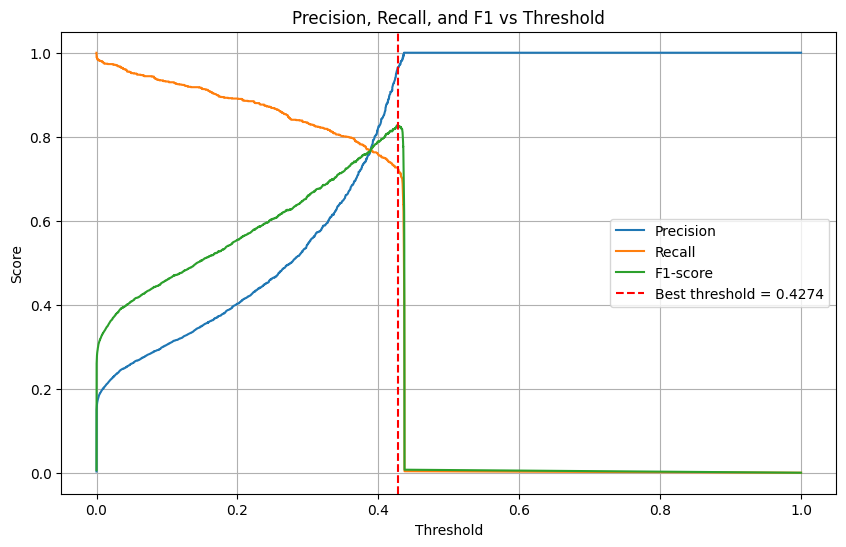

In [78]:
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
thresholds = np.append(thresholds, 1.0)

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(x=best_thresh_cal, color='red', linestyle='--', label=f'Best threshold = {best_thresh_cal:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

### Saving the models

In [79]:
import joblib

joblib.dump(calibrated_model, "fraud_detection_calibrated_model.pkl")
print("Model saved successfully.")

Model saved successfully.


In [80]:
joblib.dump(best_model, "fraud_detection_model.pkl")
print("Model saved successfully.")

Model saved successfully.
